In [1]:
from pathlib import Path
import pickle
import sys
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

project_root = str(Path().resolve().parent)
sys.path.insert(0, project_root)

In [2]:
from typing import Literal, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
import numpy as np

In [322]:
class JumpReLU(torch.autograd.Function):
    """
    Реализация JumpReLU с правильным обработчиком градиентов.
    Based on: "JumpReLU: A New Sparse Activation for Sparse Autoencoders" (2024)
    """

    @staticmethod
    def forward(ctx, input, threshold):
        # Сохраняем для обратного прохода
        ctx.save_for_backward(input, threshold)
        # Прямой проход: активации ниже порога обнуляются
        return input * (input > threshold).float()

    @staticmethod
    def backward(ctx, grad_output):
        input, threshold = ctx.saved_tensors

        # Градиент для input: пропускаем только активации выше порога
        grad_input = grad_output * (input > threshold).float()

        # Градиент для threshold: должен быть положительным чтобы УВЕЛИЧИВАТЬ порог
        # и уменьшать количество активаций
        grad_threshold = -grad_output * (input > threshold).float() * 0.1  # Меньший коэффициент

        # Суммируем по батчу и последовательности, но сохраняем по нейронам
        if grad_threshold.dim() > 1:
            grad_threshold = grad_threshold.sum(dim=tuple(range(grad_threshold.dim() - 1)))

        return grad_input, grad_threshold

class SparseAutoencoder(nn.Module):
    def __init__(
        self,
        input_dim=2560,
        latent_dim=256,
        threshold=0.1,
        geom_med=None,
        l1_coeff=1e-5
    ):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.l1_coeff = l1_coeff

        # Параметры кодировщика и декодировщика
        self.W_enc = nn.Parameter(nn.init.kaiming_uniform_(torch.empty(self.input_dim, self.latent_dim)))
        self.W_dec = nn.Parameter(nn.init.kaiming_uniform_(torch.empty(self.latent_dim, self.input_dim)))
        self.b_enc = nn.Parameter(torch.zeros(self.latent_dim))
        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)

        if geom_med is not None:
            gm = torch.as_tensor(geom_med)
            with torch.no_grad():
                self.b_dec = nn.Parameter(gm)
        else:
            self.b_dec = nn.Parameter(torch.zeros(self.input_dim))

        # Обучаемый порог для каждого нейрона
        if threshold != 0:
            self.threshold = nn.Parameter(torch.ones(latent_dim) * threshold)
        else:
            self.threshold = None

    # @torch.autocast(device_type='cuda', dtype=torch.float16)
    def forward(self, x):
        if x.dtype != torch.float16:
            x = x.half()

        x_cent = x - self.b_dec
        if self.threshold is not None:
            acts = JumpReLU.apply(x_cent @ self.W_enc + self.b_enc, self.threshold)
        else:
            acts = F.relu(x_cent @ self.W_enc + self.b_enc)
        x_reconstruct = acts @ self.W_dec + self.b_dec
        l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1).mean(0)
        l1_loss = self.l1_coeff * (acts.float().abs().sum())
        loss = l2_loss + l1_loss
        return loss, x_reconstruct, acts, l2_loss, l1_loss

    @torch.no_grad()
    def remove_parallel_component_of_grads(self):
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj

def kl_divergence(hidden_activations, rho=0.1):
    """Безопасная KL divergence с численной стабильностью"""
    # Средняя активация по батчу
    rho_hat = torch.mean(hidden_activations, dim=0)

    # Жесткое ограничение для избежания NaN
    rho_hat = torch.clamp(rho_hat, min=1e-6, max=1-1e-6)

    # Стабильная версия KL divergence
    term1 = rho * torch.log(rho / rho_hat)
    term2 = (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))

    kl = term1 + term2
    return torch.sum(kl)

def correlation_penalty(features, batch_size):
    """
    Штраф за корреляцию между активациями нейронов на одном примере.
    features: тензор [batch_size, latent_dim]
    """
    # Нормализуем активации по батчу
    features_batch_normalized = features - features.mean(dim=0, keepdim=True)

    # Вычисляем ковариационную матрицу для батча
    cov_matrix = torch.matmul(features_batch_normalized.T, features_batch_normalized) / (batch_size - 1)

    # Обнуляем диагональ (дисперсии каждого нейрона)
    n_features = cov_matrix.size(0)
    cov_matrix_flattened = cov_matrix.flatten()
    cov_matrix_flattened[::n_features + 1] = 0  # Обнуляем диагональные элементы
    cov_matrix = cov_matrix_flattened.view(n_features, n_features)

    # Штрафуем сумму квадратов недиагональных элементов
    correlation_penalty = torch.sum(cov_matrix ** 2)
    return correlation_penalty

In [4]:
class WarmupScheduler:
    def __init__(self, total_steps, sparsity_weight=1e-3):
        self.total_steps = total_steps
        self.sparsity_weight = sparsity_weight
        self.current_step = 0

    def get_sparsity_coeff(self):
        # Линейное увеличение коэффициента от 0 до sparsity_weight
        progress = min(self.current_step / self.total_steps, 1.0)
        current_coeff = progress * self.sparsity_weight
        self.current_step += 1
        return current_coeff

In [321]:
# Диагностика данных перед обучением
def detailed_data_analysis(tensors):
    all_data = torch.cat([t.float() for t in tensors], dim=0)

    stats = {
        'min': all_data.min().item(),
        'max': all_data.max().item(),
        'mean': all_data.mean().item(),
        'std': all_data.std().item()
    }

    print(f"Минимум: {stats['min']:.6f}")
    print(f"Максимум: {stats['max']:.6f}")
    print(f"Среднее: {stats['mean']:.6f}")
    print(f"Стандартное отклонение: {stats['std']:.6f}")

    return stats

def normalize(activations: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    # защитный eps чтобы не делить на 0
    eps = 1e-8

    reduce_dims = tuple(range(activations.ndim - 1))
    if len(reduce_dims) == 0:
        mean_vec = activations
    else:
        mean_vec = activations.mean(dim=reduce_dims)  # shape (d,)

    expand_shape = [1] * (activations.ndim - 1) + [activations.shape[-1]]
    mean_vec = mean_vec.reshape(*expand_shape).to(dtype=activations.dtype, device=activations.device)

    # 2) subtract mean
    centered = activations - mean_vec

    # 3) compute L2 norm per vector and normalize safely
    norms = torch.linalg.vector_norm(centered, dim=-1, keepdim=True)
    norms = norms.clamp(min=eps)

    normalized = centered / norms

    return normalized, mean_vec, norms

def denormalize(x_norm: torch.Tensor, mean_vec: torch.Tensor, norms: torch.Tensor):
    """
    Обратная трансформация: x_original = x_norm * norms + mean_vec
    Подразумевает корректное broadcast-совпадение shapes.
    """
    return x_norm * norms + mean_vec

# Улучшенная функция потерь с защитой от взрыва градиентов
def sparse_loss_function(
    original, reconstructed, hidden_activations,
    sparsity_weight=0.4
):
    # Reconstruction loss (MSE) - добавляем стабильности
    recon_loss = F.mse_loss(reconstructed, original, reduction='mean')

    # Sparsity loss
    sparsity_loss = F.l1_loss(hidden_activations, torch.zeros_like(hidden_activations))
    # sparsity_loss = kl_divergence(hidden_activations, rho=0.05)

    # Total loss
    total_loss = recon_loss + sparsity_weight * sparsity_loss

    return total_loss, recon_loss, sparsity_loss

# Процесс обучения
def train_sae(
    model, dataloader,
    optimizer: torch.optim.Adam,
    scheduler: torch.optim.lr_scheduler.OneCycleLR,
    epochs=5,
    device=None,
    sparsity_weight=0.4,
    clip_norm=0.5,
    warmup=0.05
):
    # История потерь для анализа
    history = {
        'total_loss': [],
        'recon_loss': [],
        'sparsity_loss': [],
        'active_neurons': []
    }

    for epoch in range(epochs):
        warmup_steps = int(warmup * len(dataloader))
        warmuper = WarmupScheduler(warmup_steps, sparsity_weight)

        epoch_loss = epoch_recon = epoch_sparsity = epoch_activations = 0

        # Progress bar для батчей
        batch_pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)

        for batch_idx, (batch_data,) in enumerate(batch_pbar):
            batch_data = batch_data.float().to(device)

            # Forward pass
            current_sparsity_weight = warmuper.get_sparsity_coeff()
            loss, reconstructed, hidden_activations, recon_loss, sparsity_loss = model(batch_data)

            loss.backward()
            model.remove_parallel_component_of_grads()

            # Клиппинг градиентов
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_norm)

            # Backward pass с градиентным клиппингом
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

            # Сбор статистики
            epoch_loss += loss.item()
            epoch_recon += recon_loss.item()
            epoch_sparsity += sparsity_loss.item() if not torch.isnan(sparsity_loss) else 0
            epoch_activations += torch.mean((hidden_activations > 0.00).float()).item()

            # Обновление progress bar
            if not (torch.isnan(loss) or torch.isinf(loss)):
                batch_pbar.set_postfix({
                    'Loss': f'{loss.item():.6f}',
                    'Active': f'{torch.mean((hidden_activations > 0.00).float()).item():.3f}'
                })
            else:
                batch_pbar.set_postfix({'Loss': 'NaN/Inf', 'Active': '---'})

        batch_pbar.close()

        # Статистика эпохи
        avg_loss = epoch_loss / len(dataloader)
        avg_recon = epoch_recon / len(dataloader)
        avg_sparsity = epoch_sparsity / len(dataloader)
        avg_activation = epoch_activations / len(dataloader)

        history['total_loss'].append(avg_loss)
        history['recon_loss'].append(avg_recon)
        history['sparsity_loss'].append(avg_sparsity)
        history['active_neurons'].append(avg_activation)

        print(f'Epoch {epoch+1:2d}/{epochs}: '
              f'Loss = {avg_loss:.6f}, '
              f'Recon = {avg_recon:.6f} / {recon_loss.item():.6f}, '
              f'SparsityLoss = {avg_sparsity:.6f} / {sparsity_loss.item():.6f}, '
              f'Active Neurons = {avg_activation:.3f}')
        print('-' * 80)

    return history

In [6]:
# -- Parameters (tune if needed) --
INPUT_DIM = 2560
LATENT_DIM = 256
CLIP_VAL = 100.0
BATCH_SIZE = 2048
EPOCHS = 50
LR = 5e-4

# loss weights tuned for "one neuron == one concept" bias:
LAMBDA_L1 = 0.0       # encourages numeric sparsity
LAMBDA_KL = 0.4       # enforces population sparsity frequency (rho)
RHO = 0.01             # target activation frequency per neuron (~3%)
LAMBDA_DECORR = 0.0   # modest decorrelation to separate neurons
WEIGHT_DECAY_DECODER = 1e-5
GRAD_CLIP = 0.5

# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
with open(project_root + "/data/activations/layer36.pkl", 'rb') as f:
    tensors = pickle.load(f)

In [8]:
tensors = torch.cat(tensors, dim=0)

In [ ]:
print("Диагностика данных...")
detailed_data_analysis(tensors);

Диагностика данных...
Минимум: -11824.000000
Максимум: 4020.000000
Среднее: -0.233387
Стандартное отклонение: 23.650959


In [9]:
normalized_tensors, mean_vec, norms = normalize(tensors)

In [ ]:
print("Диагностика данных...")
detailed_data_analysis(normalized_tensors);

Диагностика данных...
Минимум: -48.250000
Максимум: 18.750000
Среднее: -0.016638
Стандартное отклонение: 0.999811


In [10]:
from geom_median.torch import compute_geometric_median

geom_med = compute_geometric_median([normalized_tensors[i] for i in range(normalized_tensors.size(0))], maxiter=10)

In [11]:
# Создаем dataset и dataloader
dataloader = DataLoader(TensorDataset(normalized_tensors), batch_size=512, shuffle=False)

In [12]:
del tensors, normalized_tensors

In [13]:
import gc

gc.collect()

0

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [389]:
# Инициализация модели
input_dim = 2560
hidden_dim = 2560
model = SparseAutoencoder(
    input_dim=input_dim,
    latent_dim=hidden_dim,
    threshold=0,
    geom_med=None,
    l1_coeff=0.0001
).to(device)

WEIGHT_DECAY_DECODER = 1e-3 # 1e-2 хорошо при warmup=0.1 и sparsity_weight=1 и lr=1e-4, но 93% мертвых токенов

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(dataloader),
    epochs=1,
    pct_start=0.5,
    anneal_strategy='cos',
    div_factor=25.0,
    final_div_factor=1e4
)

print("Начало обучения...")
train_sae(
    model, dataloader, optimizer, scheduler,
    epochs=1,
    device=device,
    clip_norm=0.01,
    sparsity_weight=1,    # Сила sparse regularization
    warmup=0.1
)

print("Обучение завершено!")

Начало обучения...


Epoch 1/1:   0%|          | 0/1350 [00:00<?, ?it/s]

Epoch  1/1: Loss = 0.539968, Recon = 0.400682 / 0.252457, SparsityLoss = 0.139286 / 0.010583, Active Neurons = 0.037
--------------------------------------------------------------------------------
Обучение завершено!


In [ ]:
del model, optimizer

In [390]:
gc.collect()

33

In [388]:
torch.cuda.empty_cache()

In [391]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [392]:
import plotly.io as pio
pio.templates.default = "plotly_dark"

In [ ]:
def analyze_neuron_specialization(model, dataloader, device, num_batches=5):
    """Анализ специализации нейронов с обработкой выбросов"""
    model.eval()
    all_activations = []

    with torch.no_grad():
        for batch_idx, (batch_data,) in enumerate(dataloader):
            if batch_idx >= num_batches:
                break
            batch_data = batch_data.float().to(device)
            loss, reconstructed, hidden_activations, recon_loss, sparsity_loss = model(batch_data)
            all_activations.append(hidden_activations.cpu())

    activations = torch.cat(all_activations, dim=0)

    # Обработка выбросов для визуализации
    activation_clean = activations.numpy().copy()

    specialization_metrics = {
        'neuron_variance': torch.var(activations, dim=0).numpy(),
        'activation_rate': torch.mean((activations > 0.0).float(), dim=0).numpy(),
        'activations_clean': activation_clean,
        'activations_raw': activations.numpy()
    }

    return specialization_metrics, activations.numpy()

def plot_neuron_specialization_analysis(metrics):
    """Визуализация анализа специализации с аннотациями"""
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            '📊 ДИСПЕРСИЯ АКТИВАЦИЙ: Как сильно варьируется активность нейронов',
            '📈 ЧАСТОТА АКТИВАЦИИ: Как часто нейроны "включаются"',
            '🔗 КОРРЕЛЯЦИЯ МЕЖДУ НЕЙРОНАМИ: Насколько нейроны независимы',
            '🏆 ТОП СПЕЦИАЛИЗИРОВАННЫХ НЕЙРОНОВ'
        ),
        specs=[[{}, {}], [{}, {}]]
    )

    variance = metrics['neuron_variance']
    activation_rate = metrics['activation_rate']

    # 1. Дисперсия активаций (логарифмическая шкала из-за выбросов)
    fig.add_trace(
        go.Scatter(x=list(range(len(variance))), y=variance,
                  mode='markers', name='Дисперсия',
                  marker=dict(size=4, color=variance, colorscale='Viridis',
                             colorbar=dict(title="Дисперсия"))),
        row=1, col=1
    )
    fig.update_yaxes(type="log", row=1, col=1, title="Дисперсия (log scale)")

    # 2. Гистограмма частоты активации
    fig.add_trace(
        go.Histogram(x=activation_rate, nbinsx=30, name='Частота активации',
                    marker_color='lightgreen'),
        row=1, col=2
    )
    fig.update_xaxes(row=1, col=2, title="Процент активации")

    # 3. Взаимная корреляция (вычисляем)
    activations_clean = metrics['activations_clean']
    corr_matrix = np.corrcoef(activations_clean.T)
    np.fill_diagonal(corr_matrix, 0)
    avg_correlation = np.mean(np.abs(corr_matrix), axis=1)

    fig.add_trace(
        go.Scatter(x=list(range(len(avg_correlation))), y=avg_correlation,
                  mode='markers', name='Корреляция',
                  marker=dict(size=4, color=avg_correlation, colorscale='RdBu_r')),
        row=2, col=1
    )
    fig.update_yaxes(row=2, col=1, title="Средняя корреляция")

    # 4. Топ специализированных нейронов
    specialization_score = variance * (1 - activation_rate)
    top_indices = np.argsort(specialization_score)[-15:][::-1]

    fig.add_trace(
        go.Bar(x=[f'Нейрон {i}' for i in top_indices],
               y=specialization_score[top_indices],
               marker_color=px.colors.sequential.Viridis[:len(top_indices)]),
        row=2, col=2
    )

    fig.update_layout(
        height=800,
        title_text="🔬 ДЕТАЛЬНЫЙ АНАЛИЗ СПЕЦИАЛИЗАЦИИ НЕЙРОНОВ",
        showlegend=False
    )

    # Аннотации для интерпретации
    annotations = [
        dict(x=0.15, y=0.98, xref="paper", yref="paper",
             text="✅ <b>ХОРОШО:</b> Высокая дисперсия + несколько выбросов<br>"
                  "❌ <b>ПЛОХО:</b> Низкая дисперсия + равномерное распределение",
             showarrow=False, bgcolor="rgba(0,0,0,0.8)"),
        dict(x=0.65, y=0.98, xref="paper", yref="paper",
             text="✅ <b>ХОРОШО:</b> Бимодальное распределение (0 и 1)<br>"
                  "❌ <b>ПЛОХО:</b> Равномерное распределение",
             showarrow=False, bgcolor="rgba(0,0,0,0.8)"),
        dict(x=0.15, y=0.48, xref="paper", yref="paper",
             text="✅ <b>ХОРОШО:</b> Низкая корреляция (~0)<br>"
                  "❌ <b>ПЛОХО:</b> Высокая корреляция (>0.3)",
             showarrow=False, bgcolor="rgba(0,0,0,0.8)"),
        dict(x=0.65, y=0.48, xref="paper", yref="paper",
             text="🏆 <b>Самые специализированные нейроны</b><br>"
                  "Высокая дисперсия + низкая частота активации",
             showarrow=False, bgcolor="rgba(0,0,0,0.8)")
    ]

    fig.update_layout(annotations=annotations)
    fig.show()

    # Статистика
    print("=== ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ ===")
    print(f"🔍 Медианная дисперсия: {np.median(variance):.4f}")
    print(f"🔍 Медианная частота активации: {np.median(activation_rate):.4f}")
    print(f"🔍 Медианная корреляция: {np.median(avg_correlation):.4f}")
    print(f"🎯 Топ-3 специализированных нейрона: {top_indices[:3]}")

    if np.max(variance) > 100 * np.median(variance):
        print("⚠️  ВНИМАНИЕ: Обнаружены нейроны-выбросы с очень высокой дисперсией")
        outlier_idx = np.argmax(variance)
        print(f"    Нейрон {outlier_idx}: дисперсия = {variance[outlier_idx]:.2f}")

def plot_neuron_activation_distribution_improved(activations, num_neurons=10):
    """Улучшенное распределение активаций"""
    # Выбираем наиболее интересные нейроны (с высокой дисперсией)
    variances = np.var(activations, axis=0)
    interesting_neurons = np.argsort(variances)[-num_neurons:][::-1]

    fig = go.Figure()

    colors = px.colors.qualitative.Set3
    for i, neuron_idx in enumerate(interesting_neurons):
        neuron_activations = activations[:, neuron_idx]

        # Используем логарифмированную плотность для лучшей визуализации
        fig.add_trace(go.Histogram(
            x=neuron_activations,
            name=f'Нейрон {neuron_idx} (var: {variances[neuron_idx]:.2f})',
            opacity=0.7,
            nbinsx=50,
            marker_color=colors[i % len(colors)]
        ))

    fig.update_layout(
        title="📊 РАСПРЕДЕЛЕНИЕ АКТИВАЦИЙ НЕЙРОНОВ<br><sup>"
              "✅ <b>Хорошо</b> = Бимодальное распределение (нейрон либо включен, либо выключен)<br>"
              "❌ <b>Плохо</b> = Нормальное распределение (нейрон всегда немного активен)</sup>",
        xaxis_title="Значение активации",
        yaxis_title="Частота (log scale)",
        barmode='overlay',
        yaxis_type="log"
    )
    fig.update_traces(opacity=0.6)
    fig.show()

def visualize_latent_space_improved(activations, method='pca'):
    """Улучшенная визуализация скрытого пространства"""
    from sklearn.manifold import TSNE
    from sklearn.decomposition import PCA

    # Берем подвыборку для скорости
    subset_size = min(2000, len(activations))
    indices = np.random.choice(len(activations), subset_size, replace=False)
    activations_subset = activations[indices]

    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
        embeddings = reducer.fit_transform(activations_subset)
        title_suffix = "t-SNE"
        interpretation = "Кластеры = семантически похожие примеры"
    else:
        reducer = PCA(n_components=2)
        embeddings = reducer.fit_transform(activations_subset)
        title_suffix = f"PCA (объяснено: {reducer.explained_variance_ratio_.sum():.1%})"
        interpretation = "Направления = главные компоненты вариативности данных"

    # Создаем цвет на основе плотности точек
    from scipy.stats import gaussian_kde
    if len(embeddings) > 100:
        kde = gaussian_kde(embeddings.T)
        density = kde(embeddings.T)
    else:
        density = np.ones(len(embeddings))

    fig = px.scatter(
        x=embeddings[:, 0], y=embeddings[:, 1],
        color=density,
        title=f"🧭 СКРЫТОЕ ПРОСТРАНСТВО ({title_suffix})<br><sup>"
              f"{interpretation}<br>"
              "✅ <b>Хорошо</b> = Структурированное пространство с кластерами<br>"
              "❌ <b>Плохо</b> = Равномерный шар или одна плотная точка</sup>",
        color_continuous_scale="Viridis"
    )

    fig.update_layout(
        xaxis_title="Компонента 1",
        yaxis_title="Компонента 2",
        coloraxis_colorbar=dict(title="Плотность"),
        height=900
    )

    # Анализ структуры
    from sklearn.cluster import DBSCAN
    if len(embeddings) > 100:
        clustering = DBSCAN(eps=0.5, min_samples=10).fit(embeddings)
        n_clusters = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)

        fig.add_annotation(
            x=0.02, y=0.98, xref="paper", yref="paper",
            text=f"Обнаружено кластеров: {n_clusters}",
            showarrow=False, bgcolor="black", bordercolor="white"
        )

    fig.show()

    # Интерпретация формы
    x_range = np.ptp(embeddings[:, 0])
    y_range = np.ptp(embeddings[:, 1])
    aspect_ratio = y_range / x_range if x_range > 0 else 1

    print("=== ИНТЕРПРЕТАЦИЯ СКРЫТОГО ПРОСТРАНСТВА ===")
    if aspect_ratio < 0.3 or aspect_ratio > 3:
        print("📐 Обнаружена вытянутая структура: данные имеют четкое направление максимальной вариативности")
    elif n_clusters > 1:
        print("🔷 Обнаружены кластеры: модель выделяет различные типы данных")
    else:
        print("⚪ Равномерное распределение: либо данные однородны, либо нужна более сложная модель")

# Запуск улучшенного анализа
def comprehensive_analysis_improved(model, dataloader, device):
    print("=== 🎯 АНАЛИЗ МОДЕЛИ ===")

    metrics, activations = analyze_neuron_specialization(model, dataloader, device)

    print("\n1. 📊 АНАЛИЗ СПЕЦИАЛИЗАЦИИ НЕЙРОНОВ")
    plot_neuron_specialization_analysis(metrics)

    print("\n3. 📊 РАСПРЕДЕЛЕНИЯ АКТИВАЦИЙ")
    plot_neuron_activation_distribution_improved(metrics['activations_clean'])

    # print("\n4. 🧭 СКРЫТОЕ ПРОСТРАНСТВО")
    visualize_latent_space_improved(metrics['activations_clean'], method='tsne')

    print("\n" + "="*50)
    print("🎉 АНАЛИЗ ЗАВЕРШЕН!")

# Запускаем улучшенный анализ
comprehensive_analysis_improved(model, dataloader, device)

In [29]:
def analyze_neuron_specialization(model, dataloader, device, num_batches=5):
    """Анализ специализации нейронов с обработкой выбросов"""
    model.eval()
    all_activations = []

    with torch.no_grad():
        for batch_idx, (batch_data,) in enumerate(dataloader):
            if batch_idx >= num_batches:
                break
            batch_data = batch_data.to(device)
            hidden_activations, _ = model(batch_data)
            all_activations.append(hidden_activations.cpu())

    activations = torch.cat(all_activations, dim=0)

    # Обработка выбросов для визуализации
    activation_clean = activations.numpy().copy()

    # Заменяем выбросы на 99-й процентиль
    for i in range(activation_clean.shape[1]):
        p99 = np.percentile(activation_clean[:, i], 99)
        activation_clean[:, i] = np.clip(activation_clean[:, i], 0, p99)

    specialization_metrics = {
        'neuron_variance': torch.var(activations, dim=0).numpy(),
        'activation_rate': torch.mean((activations > 0.1).float(), dim=0).numpy(),
        'activations_clean': activation_clean,
        'activations_raw': activations.numpy()
    }

    return specialization_metrics, activations.numpy()

def visualize_activation_patterns_improved(activations, num_neurons=100000, num_samples=500, orientation: Literal["neuron", "token"] = "neuron"):
    """Улучшенная визуализация паттернов активации с min-max нормализацией по токенам"""
    order = ["neuron", "token"]
    # Ограничиваем количество примеров и нейронов для визуализации
    activations_subset = activations[:num_samples, :min(num_neurons, activations.shape[1])]

    print(f"Форма данных для визуализации: {activations_subset.shape}")

    # Min-max нормализация по каждому токену (по axis=1 - нейроны)
    # Для каждого токена: (активация - min) / (max - min)
    min_vals = np.min(activations_subset, axis=order.index(orientation), keepdims=True)
    max_vals = np.max(activations_subset, axis=order.index(orientation), keepdims=True)
    range_vals = max_vals - min_vals

    # Избегаем деления на ноль
    range_vals[range_vals == 0] = 1

    activations_normalized = (activations_subset - min_vals) / range_vals

    fig = px.imshow(
        activations_normalized.T,  # Транспонируем для правильной ориентации
        title="🎨 ПАТТЕРНЫ АКТИВАЦИИ НЕЙРОНОВ (Min-Max нормализация)<br><sup>"
              "✅ <b>Темные области</b> = низкая активация | "
              "🟡 <b>Яркие области</b> = высокая относительная активация<br>"
              "📊 <b>Min-Max нормализация</b> = для каждого токена: min=0, max=1 | "
              "✅ <b>Хорошо</b> = Разные паттерны для разных примеров</sup>",
        color_continuous_scale="Viridis",
        aspect="auto",
        zmin=0,  # Явно задаем диапазон цветовой шкалы
        zmax=1   # От 0 до 1 после нормализации
    )

    fig.update_layout(
        xaxis_title="Токены",
        yaxis_title="Нейроны",
        coloraxis_colorbar=dict(title="Нормализованная<br>активация")
    )

    return fig

In [394]:
model.eval()

lst = []
avg_ve = 0
avg_per_coor = np.zeros((2560,), dtype=np.float16)

with torch.no_grad():
    for batch_idx, (batch_data,) in enumerate(dataloader):

        batch_data = batch_data.float().to(device)
        loss, reconstructed, hidden_activations, recon_loss, sparsity_loss = model(batch_data)

        diff = batch_data - torch.Tensor(reconstructed)
        num = torch.var(diff, unbiased=True)
        den = torch.var(batch_data, unbiased=True)

        avg_ve += (1.0 - num / (den + 1e-8)).item()

        num = torch.var(diff, dim=(0,), unbiased=True)
        den = torch.var(batch_data, dim=(0,), unbiased=True)
        ve_per_coor = 1.0 - num / (den + 1e-8)
        avg_per_coor += ve_per_coor.cpu().numpy().astype(np.float16)

        lst.append(hidden_activations.cpu().numpy().astype(np.float16))
        # Очистка памяти
        del batch_data, reconstructed, hidden_activations, loss, recon_loss, sparsity_loss
        torch.cuda.empty_cache()

avg_ve = avg_ve / (batch_idx + 1)
avg_per_coor = avg_per_coor / (batch_idx + 1)
lst = np.concatenate(lst, axis=0)

In [395]:
print(f"Средний VE по батчам: {avg_ve:.4f}")
px.histogram(avg_per_coor)

Средний VE по батчам: 0.7317


Мы видим несколько перекошенное распределение. Это нам может говорить о том, что обученная модель по большей мере сфокусировалась именно на наболее однородных конептах, перетекающих в соответствующие оси. На более общих и менее представленных в датасете концептах модель имеет проблемы с реконструкцией, то есть это фактически недообученность

In [ ]:
visualize_activation_patterns_improved(lst, num_samples=2_048, num_neurons=8_192, orientation="neuron").update_layout(height=1000)

In [ ]:
visualize_activation_patterns_improved(lst, num_samples=2_048, num_neurons=8_192, orientation="token").update_layout(height=1000)

In [397]:
round((float(sum((lst == 0).all(axis=0)) / lst.shape[1]) * 100), 2)

2.62

In [33]:
import matplotlib.pyplot as plt

def plot_feature_density_distribution(activations_matrix, bins=50, density_range=(-8, 0)):
    """
    Строит распределение плотности фичей (feature density) по нейронам.

    Args:
        activations_matrix: numpy array формы [samples, features]
        bins: количество бинов для гистограммы
        density_range: диапазон для log10 плотности (по умолчанию от 10^-4 до 10^0)
    """
    # Вычисляем плотность для каждого нейрона (доля ненулевых активаций)
    # activations_matrix имеет форму [samples, features]
    feature_density = np.mean(activations_matrix > 0, axis=0)

    # Берем log10 от плотности, избегая log(0)
    # Добавляем очень маленькое значение чтобы избежать -inf
    log_density = np.log10(feature_density + 1e-7)

    # Строим гистограмму
    plt.figure(figsize=(10, 6))

    # Гистограмма с нормализацией чтобы получить долю нейронов
    counts, bin_edges, patches = plt.hist(log_density, bins=bins,
                                         density=True,  # Нормализуем к доле нейронов
                                         alpha=0.7,
                                         color='skyblue',
                                         edgecolor='black')

    plt.xlabel('log10(Feature Density)')
    plt.ylabel('Fraction of Neurons')
    plt.title('Feature Density Distribution')

    # Добавляем вертикальные линии для ориентиров
    plt.axvline(np.log10(0.01), color='red', linestyle='--', alpha=0.7,
               label='1% density (log10=-2)')
    plt.axvline(np.log10(0.1), color='orange', linestyle='--', alpha=0.7,
               label='10% density (log10=-1)')

    # Устанавливаем пределы если заданы
    if density_range:
        plt.xlim(density_range)

    plt.legend()
    plt.grid(True, alpha=0.3)

    # Добавляем вторую ось сверху с линейной шкалой
    ax2 = plt.gca().twiny()
    ax2.set_xlim(10**density_range[0], 10**density_range[1])
    ax2.set_xlabel('Feature Density (linear scale)')
    ax2.set_xscale('log')

    plt.tight_layout()
    plt.show()

    # Выводим статистику
    print("Статистика распределения плотности фичей:")
    print(f"Всего нейронов: {len(feature_density)}")
    print(f"Медианная плотность: {np.median(feature_density):.6f} ({np.median(feature_density)*100:.4f}%)")
    print(f"Средняя плотность: {np.mean(feature_density):.6f} ({np.mean(feature_density)*100:.4f}%)")
    print(f"Минимальная плотность: {np.min(feature_density):.6f}")
    print(f"Максимальная плотность: {np.max(feature_density):.6f}")

    # Статистика по категориям плотности
    dead_neurons = np.sum(feature_density == 0)
    very_sparse = np.sum(feature_density < 1e-4)
    sparse = np.sum(feature_density < 1e-2)
    common = np.sum(feature_density > 0.1)

    print(f"\nКатегории нейронов:")
    print(f"Мертвые нейроны (density=0): {dead_neurons} ({dead_neurons/len(feature_density)*100:.2f}%)")
    print(f"Очень разреженные (density<0.01%): {very_sparse} ({very_sparse/len(feature_density)*100:.2f}%)")
    print(f"Разреженные (density<1%): {sparse} ({sparse/len(feature_density)*100:.2f}%)")
    print(f"Частые (density>10%): {common} ({common/len(feature_density)*100:.2f}%)")

    return feature_density, log_density

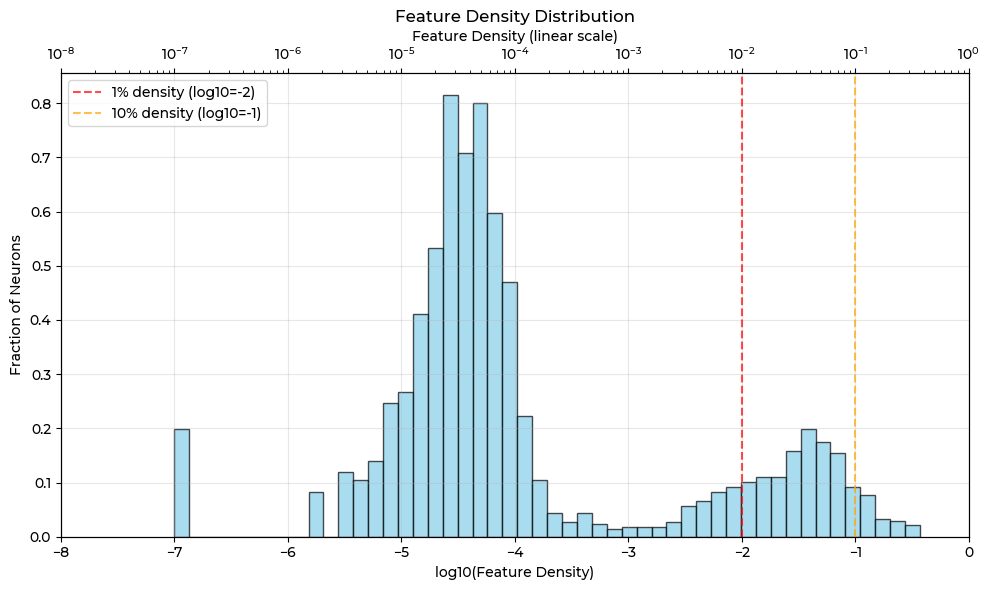

Статистика распределения плотности фичей:
Всего нейронов: 2560
Медианная плотность: 0.000045 (0.0045%)
Средняя плотность: 0.010125 (1.0125%)
Минимальная плотность: 0.000000
Максимальная плотность: 0.371466

Категории нейронов:
Мертвые нейроны (density=0): 67 (2.62%)
Очень разреженные (density<0.01%): 1835 (71.68%)
Разреженные (density<1%): 2136 (83.44%)
Частые (density>10%): 63 (2.46%)


(array([2.17144263e-05, 5.64575085e-05, 1.20153159e-04, ...,
        4.63241095e-05, 4.27339910e-03, 2.02667979e-05], shape=(2560,)),
 array([-4.6612562 , -4.24750973, -3.91990351, ..., -4.33325642,
        -2.36921638, -4.69107725], shape=(2560,)))

In [398]:
activations_2d = lst

# Строим гистограммы
plot_feature_density_distribution(activations_2d)

In [ ]:
import numpy as np
import plotly.graph_objects as go
import torch
from typing import Dict, Optional, Tuple, Any, List, Union


# TODO: Typing for model param conflicts with weights extraction
def compute_feature_statistics(
    model: Any,
    activations_data: Union[np.ndarray, torch.Tensor, List],
    sample_size: int = 10000
) -> Dict[str, np.ndarray]:
    """
    Compute comprehensive statistics for Sparse Autoencoder (SAE) features.

    Analyzes activation patterns and encoder-decoder relationships to compute
    various feature metrics including density, bias, and reconstruction contributions.

    Parameters
    ----------
    model : torch.nn.Module
        SAE model with W_enc, W_dec, and optionally b_enc attributes
    activations_data : Union[np.ndarray, torch.Tensor, List]
        Activation data of shape (N, p) where N is number of samples, p is features
    sample_size : int, optional
        Maximum number of samples to use for computation, by default 10000

    Returns
    -------
    Dict[str, np.ndarray]
        Dictionary containing feature statistics:
        - density: Fraction of non-zero activations per feature
        - bias: Encoder bias values for each feature
        - de_dot: Dot product between encoder and decoder weights
        - de_cosine: Cosine similarity between encoder and decoder weights
        - de_frac_energy: Fraction of energy preserved in encoder-decoder loop
        - de_proj_coeff: Projection coefficient between encoder and decoder
        - recon_contrib: Relative contribution to reconstruction variance

    Examples
    --------
    >>> model = SparseAutoencoder()
    >>> activations = np.random.randn(5000, 256)
    >>> stats = compute_feature_statistics(model, activations)
    >>> print(stats['density'].shape)
    (256,)
    """
    model.eval()

    # Subsample data if larger than sample_size
    N = len(activations_data)
    if N > sample_size:
        idx = np.random.choice(N, size=sample_size, replace=False)
        acts = activations_data[idx]
    else:
        acts = activations_data

    # Convert to torch tensor if needed
    if isinstance(acts, (np.ndarray, list)):
        acts_t = torch.tensor(acts, dtype=torch.float32)
    else:
        acts_t = acts.float()

    with torch.no_grad():
        # Compute activation density (fraction of non-zero activations)
        density = (acts_t > 0).float().mean(dim=0).cpu().numpy()

        # Compute variance of latent activations
        var_z = acts_t.var(dim=0, unbiased=False).cpu().numpy()

        # Extract encoder and decoder weights
        encoder_eff = model.W_enc.data.cpu().numpy().copy()  # shape (p, n)
        decoder_eff = model.W_dec.data.cpu().numpy().copy()  # shape (n, p)

        p = encoder_eff.shape[0]
        de_dot = np.zeros(p, dtype=np.float32)
        de_cos = np.zeros(p, dtype=np.float32)
        de_frac_energy = np.zeros(p, dtype=np.float32)
        de_proj_coeff = np.zeros(p, dtype=np.float32)
        dec_norms = np.zeros(p, dtype=np.float32)

        # Compute encoder-decoder relationships for each feature
        for i in range(p):
            e = encoder_eff[i, :]  # Encoder weights for feature i
            d = decoder_eff[:, i]  # Decoder weights for feature i

            dot = float(np.dot(d, e))
            ne = np.linalg.norm(e)
            nd = np.linalg.norm(d)
            cos = dot / ((ne * nd) + 1e-12)
            frac_energy = cos * cos
            proj_coeff = dot / (ne * ne + 1e-12)

            de_dot[i] = dot
            de_cos[i] = cos
            de_frac_energy[i] = frac_energy
            de_proj_coeff[i] = proj_coeff
            dec_norms[i] = nd

        # Compute reconstruction contribution proportional to variance explained
        recon_contrib_raw = var_z * (dec_norms ** 2)
        recon_contrib = recon_contrib_raw / (recon_contrib_raw.sum() + 1e-12)

        # Extract encoder bias if available
        if model.b_enc is not None:
            bias = model.b_enc.data.cpu().numpy().astype(np.float32)
        else:
            bias = np.zeros(p, dtype=np.float32)

    return {
        'density': density,
        'bias': bias,
        'de_dot': de_dot,
        'de_cosine': de_cos,
        'de_frac_energy': de_frac_energy,
        'de_proj_coeff': de_proj_coeff,
        'recon_contrib': recon_contrib
    }

def visualize_sae_features_3d(
    feature_stats: Dict[str, np.ndarray],
    num_features: Optional[int] = None,
    ev: Optional[float] = None,
    top_k: int = 20,
    alpha_de: float = 0.6,
    density_target_log10: float = -2.5,
    density_sigma: float = 0.5
) -> Tuple[go.Figure, Dict[str, np.ndarray]]:
    """
    Create 3D visualization of SAE features with interpretability scoring.

    Generates an interactive 3D scatter plot showing features along three axes:
    encoder-decoder cosine similarity, log10 density, and encoder bias. Features
    are colored by interpretability score and sized by reconstruction contribution.

    Parameters
    ----------
    feature_stats : Dict[str, np.ndarray]
        Dictionary of feature statistics from _compute_feature_statistics
    num_features : Optional[int], optional
        Number of features to subsample for visualization, by default None (use all)
    ev : Optional[float], optional
        Explained variance value for title, by default None
    top_k : int, optional
        Number of top features to highlight, by default 20
    alpha_de : float, optional
        Weight of D/E cosine in interpretability score (0-1), by default 0.6
    density_target_log10 : float, optional
        Target log10 density for interpretability scoring, by default -2.5
    density_sigma : float, optional
        Width of Gaussian for density scoring in log10 space, by default 0.5

    Returns
    -------
    Tuple[go.Figure, Dict[str, np.ndarray]]
        Plotly Figure object and extended statistics dictionary

    Examples
    --------
    >>> stats = _compute_feature_statistics(model, activations)
    >>> fig, extended_stats = visualize_sae_features_3d(stats, top_k=10)
    >>> fig.show()
    """
    feature_stats = feature_stats.copy()
    p = feature_stats['density'].shape[0]

    # Subsample features if requested
    if (num_features is not None) and (num_features < p):
        idx = np.random.choice(p, size=num_features, replace=False)
        for key in feature_stats:
            feature_stats[key] = feature_stats[key][idx]

    # Extract base statistics
    density = feature_stats['density']
    density_log10 = np.log10(np.clip(density, 1e-12, None))
    de_cos = feature_stats['de_cosine']
    de_frac = feature_stats['de_frac_energy']
    proj_coeff = feature_stats['de_proj_coeff']
    raw_dot = feature_stats['de_dot']
    bias = feature_stats['bias']
    recon_contrib = feature_stats['recon_contrib']

    # Compute interpretability score combining D/E cosine and density proximity
    de_norm = (de_cos + 1.0) / 2.0  # Normalize cosine from [-1,1] to [0,1]
    dist = np.abs(density_log10 - density_target_log10)
    density_score = np.exp(-0.5 * (dist / max(1e-6, density_sigma))**2)
    alpha_de = float(np.clip(alpha_de, 0.0, 1.0))
    interpret_raw = alpha_de * de_norm + (1.0 - alpha_de) * density_score
    interp_min, interp_max = interpret_raw.min(), interpret_raw.max()
    interpretability = (interpret_raw - interp_min) / (max(1e-12, interp_max - interp_min))

    # Scale marker sizes by reconstruction contribution
    recon_norm = recon_contrib / (recon_contrib.max() + 1e-12)
    marker_sizes = 6.0 + 38.0 * np.sqrt(recon_norm)
    marker_sizes = np.clip(marker_sizes, 3.0, 60.0)

    # Create density masks for categorization
    low_thresh, high_thresh = -4.0, -1.0
    low_mask = density_log10 < low_thresh
    mid_mask = (density_log10 >= low_thresh) & (density_log10 < high_thresh)
    high_mask = density_log10 >= high_thresh

    # Identify top features by reconstruction contribution
    top_k = int(min(top_k, len(recon_contrib)))
    top_idx = np.argsort(recon_contrib)[-top_k:]

    fig = go.Figure()

    # Low density features trace with colorbar
    fig.add_trace(go.Scatter3d(
        x=de_cos[low_mask],
        y=density_log10[low_mask],
        z=bias[low_mask],
        mode='markers',
        marker=dict(
            size=marker_sizes[low_mask],
            color=interpretability[low_mask],
            colorscale='Turbo',
            cmin=0.0, cmax=1.0,
            colorbar=dict(title='Interpretability', x=0.92),
            opacity=0.7,
            line=dict(width=0)
        ),
        text=[
            f"feat={i}<br>interp={interpretability[i]:.3f}<br>"
            f"D/E cos={de_cos[i]:.3f} (frac={de_frac[i]:.3f})<br>"
            f"proj_coeff={proj_coeff[i]:.3f}<br>"
            f"density={density[i]:.4f} (log10={density_log10[i]:.3f})<br>"
            f"bias={bias[i]:.4f}<br>recon_frac={recon_contrib[i]:.4f}"
            for i in np.where(low_mask)[0]
        ],
        hovertemplate='%{text}<extra></extra>',
        name=f'Low Density (log10 < {low_thresh})'
    ))

    # Medium density features
    fig.add_trace(go.Scatter3d(
        x=de_cos[mid_mask],
        y=density_log10[mid_mask],
        z=bias[mid_mask],
        mode='markers',
        marker=dict(
            size=marker_sizes[mid_mask],
            color=interpretability[mid_mask],
            colorscale='Turbo',
            showscale=False,
            opacity=0.85,
            line=dict(width=0)
        ),
        text=[
            f"feat={i}<br>interp={interpretability[i]:.3f}<br>"
            f"D/E cos={de_cos[i]:.3f} (frac={de_frac[i]:.3f})<br>"
            f"proj_coeff={proj_coeff[i]:.3f}<br>"
            f"density={density[i]:.4f} (log10={density_log10[i]:.3f})<br>"
            f"bias={bias[i]:.4f}<br>recon_frac={recon_contrib[i]:.4f}"
            for i in np.where(mid_mask)[0]
        ],
        hovertemplate='%{text}<extra></extra>',
        name='Medium Density'
    ))

    # High density features
    fig.add_trace(go.Scatter3d(
        x=de_cos[high_mask],
        y=density_log10[high_mask],
        z=bias[high_mask],
        mode='markers',
        marker=dict(
            size=marker_sizes[high_mask],
            color=interpretability[high_mask],
            colorscale='Turbo',
            showscale=False,
            opacity=0.95,
            line=dict(width=0)
        ),
        text=[
            f"feat={i}<br>interp={interpretability[i]:.3f}<br>"
            f"D/E cos={de_cos[i]:.3f} (frac={de_frac[i]:.3f})<br>"
            f"proj_coeff={proj_coeff[i]:.3f}<br>"
            f"density={density[i]:.4f} (log10={density_log10[i]:.3f})<br>"
            f"bias={bias[i]:.4f}<br>recon_frac={recon_contrib[i]:.4f}"
            for i in np.where(high_mask)[0]
        ],
        hovertemplate='%{text}<extra></extra>',
        name=f'High Density (log10 ≥ {high_thresh})'
    ))

    # Top features overlay with diamond markers
    fig.add_trace(go.Scatter3d(
        x=de_cos[top_idx],
        y=density_log10[top_idx],
        z=bias[top_idx],
        mode='markers+text',
        marker=dict(
            size=(marker_sizes[top_idx] * 1.6),
            color=interpretability[top_idx],
            colorscale='Turbo',
            showscale=False,
            opacity=1.0,
            symbol='diamond',
            line=dict(width=5, color='white')
        ),
        text=[f"#{i}" for i in top_idx],
        textposition="top center",
        hovertemplate=(
            "<b>%{text}</b><br>"
            "interp=%{marker.color:.3f}<br>"
            "D/E cos=%{x:.3f}<br>"
            "density=%{y:.4f} (log10=%{y:.3f})<br>"
            "bias=%{z:.4f}<extra></extra>"
        ),
        name=f'Top {top_k}'
    ))

    # Configure layout and title
    title = '3D SAE features — X: D/E (cos) | Y: log10(density) | Z: encoder bias'
    if ev is not None:
        title += f' — model VE={ev:.3f}'

    fig.update_layout(
        title=title,
        template='plotly_dark',
        scene=dict(
            xaxis=dict(title='D/E (cosine)'),
            yaxis=dict(title='log10(Feature density)'),
            zaxis=dict(title='Encoder bias'),
            aspectmode='manual',
            aspectratio=dict(x=1.2, y=1.0, z=0.6),
            camera=dict(eye=dict(x=0.9, y=0.9, z=0.6))
        ),
        width=1800,
        height=1200,
        legend=dict(x=0.02, y=0.98)
    )

    # Prepare extended statistics output
    out_stats = {
        'density': density,
        'density_log10': density_log10,
        'bias': bias,
        'de_cosine': de_cos,
        'de_frac_energy': de_frac,
        'de_proj_coeff': proj_coeff,
        'de_dot': raw_dot,
        'recon_contrib': recon_contrib,
        'interpretability': interpretability,
        'marker_sizes': marker_sizes,
    }

    return fig, out_stats

In [ ]:
feature_stats = compute_feature_statistics(model, lst, sample_size=50000)

In [ ]:
fig, stats = visualize_sae_features_3d(feature_stats, ev=avg_ve, top_k=50, alpha_de=0.6, density_target_log10=-2.0)

In [401]:
fig

In [39]:
print(model.b_enc.mean().item(), model.b_enc.std().item())

-0.0075432597659528255 0.0033862099517136812


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.decomposition import PCA

def analyze_neurons_from_critical_points(model, stats, n_neurons=16):
    """
    Анализ нейронов из ключевых точек распределения
    """
    density = stats['density']
    de_proj = stats['de_proj_coeff']
    log_density = np.log10(density + 1e-8)  # Защита от log(0)

    # Определяем критические регионы
    regions = {
        'low_low': {'density_range': (-4.5, -3.5), 'de_range': (0.0, 0.1)},
        'medium_medium': {'density_range': (-1.8, -1.2), 'de_range': (0.2, 0.4)},  # Около точки B
        'high_high': {'density_range': (-0.7, -0.3), 'de_range': (0.9, 1.0)}       # Около точки D
    }

    selected_neurons = {}

    for region_name, ranges in regions.items():
        density_mask = (log_density >= ranges['density_range'][0]) & (log_density <= ranges['density_range'][1])
        de_mask = (de_proj >= ranges['de_range'][0]) & (de_proj <= ranges['de_range'][1])
        mask = density_mask & de_mask

        if np.sum(mask) > 0:
            # Выбираем случайные нейроны из региона
            available_indices = np.where(mask)[0]
            if len(available_indices) > n_neurons:
                selected_indices = np.random.choice(available_indices, n_neurons, replace=False)
            else:
                selected_indices = available_indices

            selected_neurons[region_name] = {
                'indices': selected_indices,
                'density': density[selected_indices],
                'de_projection': de_proj[selected_indices],
                'bias': stats['bias'][selected_indices]
            }

    return selected_neurons

def visualize_neuron_weights_fixed(model, selected_neurons):
    """
    ИСПРАВЛЕННАЯ версия визуализации весов
    """
    model.eval()
    encoder_weights = model.encoder.weight.data.cpu().numpy()
    decoder_weights = model.decoder.weight.data.cpu().numpy()

    fig, axes = plt.subplots(3, 2, figsize=(20, 15))
    regions = ['low_low', 'medium_medium', 'high_high']

    for i, region in enumerate(regions):
        if region not in selected_neurons:
            continue

        neurons = selected_neurons[region]

        # ЭНКОДЕР - левый столбец
        ax_enc = axes[i, 0]
        for j, idx in enumerate(neurons['indices']):
            enc_weights = encoder_weights[idx]
            top_indices = np.argsort(np.abs(enc_weights))[-20:]
            top_weights = enc_weights[top_indices]

            x_pos = np.arange(len(top_weights))
            ax_enc.bar(x_pos + j*0.2, top_weights, width=0.2,
                      alpha=0.7, label=f'Neuron {idx}')

        ax_enc.set_title(f'{region.upper()} - Encoder Weights')
        ax_enc.set_xlabel('Input Feature Index (Top 20)')
        ax_enc.set_ylabel('Weight Value')
        ax_enc.legend()

        # ДЕКОДЕР - правый столбец
        ax_dec = axes[i, 1]
        for j, idx in enumerate(neurons['indices']):
            dec_weights = decoder_weights[:, idx]
            top_indices = np.argsort(np.abs(dec_weights))[-20:]
            top_weights = dec_weights[top_indices]

            x_pos = np.arange(len(top_weights))
            ax_dec.bar(x_pos + j*0.2, top_weights, width=0.2,
                      alpha=0.7, label=f'Neuron {idx}')

        ax_dec.set_title(f'{region.upper()} - Decoder Weights')
        ax_dec.set_xlabel('Output Feature Index (Top 20)')
        ax_dec.set_ylabel('Weight Value')
        ax_dec.legend()

    plt.tight_layout()
    plt.show()


    # Дополнительная визуализация: PCA проекции
    visualize_pca_projection(encoder_weights, decoder_weights, selected_neurons)

def visualize_pca_projection(encoder_weights, decoder_weights, selected_neurons):
    """
    PCA проекция весов для визуализации структуры
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # PCA для энкодера
    pca_enc = PCA(n_components=2)
    enc_proj = pca_enc.fit_transform(encoder_weights)

    # PCA для декодера
    pca_dec = PCA(n_components=2)
    dec_proj = pca_dec.fit_transform(decoder_weights.T)  # Транспонируем для совместимости

    colors = {'low_low': 'red', 'medium_medium': 'orange', 'high_high': 'green'}

    # Визуализация энкодера
    ax1.scatter(enc_proj[:, 0], enc_proj[:, 1], alpha=0.1, color='gray', s=1)
    for region, neurons in selected_neurons.items():
        indices = neurons['indices']
        ax1.scatter(enc_proj[indices, 0], enc_proj[indices, 1],
                   color=colors[region], label=region, s=50)
    ax1.set_title('Encoder Weights PCA')
    ax1.legend()

    # Визуализация декодера
    ax2.scatter(dec_proj[:, 0], dec_proj[:, 1], alpha=0.1, color='gray', s=1)
    for region, neurons in selected_neurons.items():
        indices = neurons['indices']
        ax2.scatter(dec_proj[indices, 0], dec_proj[indices, 1],
                   color=colors[region], label=region, s=50)
    ax2.set_title('Decoder Weights PCA')
    ax2.legend()

    plt.tight_layout()
    plt.show()

def print_neuron_statistics(selected_neurons):
    """
    Вывод статистики по выбранным нейронам
    """
    print("=" * 80)
    print("АНАЛИЗ НЕЙРОНОВ ИЗ КРИТИЧЕСКИХ ТОЧЕК")
    print("=" * 80)

    for region, neurons in selected_neurons.items():
        print(f"\n--- {region.upper()} ---")
        print(f"Количество нейронов: {len(neurons['indices'])}")
        print(f"Плотность: {neurons['density']}")
        print(f"D/E проекция: {neurons['de_projection']}")
        print(f"Смещение: {neurons['bias']}")
        print(f"Индексы нейронов: {neurons['indices']}")

# Использование:
def comprehensive_neuron_analysis(model, stats):
    """
    Комплексный анализ нейронов
    """
    # Выбираем нейроны из критических точек
    selected_neurons = analyze_neurons_from_critical_points(model, stats)

    # Выводим статистику
    print_neuron_statistics(selected_neurons)

    # Визуализируем веса
    visualize_neuron_weights_fixed(model, selected_neurons)

    return selected_neurons

# Запуск анализа
selected_neurons = comprehensive_neuron_analysis(model, stats)

In [ ]:
def interpret_encoder_decoder_pattern(encoder_pca, decoder_pca, selected_neurons):
    """
    Создание интерпретирующих визуализаций для наблюдаемых паттернов
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # 1. Энкодер - с аннотациями
    colors = {'low_low': 'red', 'medium_medium': 'orange', 'high_high': 'green'}

    for region, neurons in selected_neurons.items():
        indices = neurons['indices']
        ax1.scatter(encoder_pca[indices, 0], encoder_pca[indices, 1],
                   color=colors[region], label=region, s=60, alpha=0.8)

    ax1.set_title('ЭНКОДЕР: Детекторы признаков\n(В основном случайный поиск)', fontsize=14)
    ax1.set_xlabel('PC1: Общая специализация')
    ax1.set_ylabel('PC2: Специфичность признаков')
    ax1.legend()

    # Аннотация для high-high смещения
    if 'high_high' in selected_neurons:
        hh_indices = selected_neurons['high_high']['indices']
        if len(hh_indices) > 0:
            mean_x = np.mean(encoder_pca[hh_indices, 0])
            mean_y = np.mean(encoder_pca[hh_indices, 1])
            ax1.annotate('Нашли систематические\nharmful паттерны',
                        xy=(mean_x, mean_y), xytext=(mean_x-1, mean_y+0.5),
                        arrowprops=dict(arrowstyle='->', color='green'),
                        fontsize=10, color='green')

    # 2. Декодер - с аннотациями и прогрессией
    for region, neurons in selected_neurons.items():
        indices = neurons['indices']
        ax2.scatter(decoder_pca[indices, 0], decoder_pca[indices, 1],
                   color=colors[region], label=region, s=60, alpha=0.8)

    ax2.set_title('ДЕКОДЕР: Конструкторы выхода\n(Чёткая иерархия влияния)', fontsize=14)
    ax2.set_xlabel('PC1: Сила влияния на реконструкцию →')
    ax2.set_ylabel('PC2: Разнообразие вносимых признаков')
    ax2.legend()

    # Аннотации для прогрессии
    regions_order = ['low_low', 'medium_medium', 'high_high']
    for i, region in enumerate(regions_order):
        if region in selected_neurons:
            indices = selected_neurons[region]['indices']
            if len(indices) > 0:
                mean_x = np.mean(decoder_pca[indices, 0])
                mean_y = np.mean(decoder_pca[indices, 1])

                labels = {
                    'low_low': 'Слабые влияния\n(наблюдатели)',
                    'medium_medium': 'Умеренные влияния\n(специалисты)',
                    'high_high': 'Сильные разнонаправленные\nвлияния (архитекторы)'
                }

                ax2.annotate(labels[region],
                            xy=(mean_x, mean_y),
                            xytext=(mean_x-0.5, mean_y + (0.3 if i == 2 else -0.3)),
                            arrowprops=dict(arrowstyle='->', color=colors[region]),
                            fontsize=9, color=colors[region])

    plt.tight_layout()
    plt.show()

# Дополнительная функция для анализа "силы влияния"
def analyze_reconstruction_influence(model, selected_neurons, sample_data):
    """
    Анализ того, как разные нейроны влияют на реконструкцию
    """
    model.eval()

    with torch.no_grad():
        # Берем пример данных
        sample = sample_data[:1]  # Один пример

        # Базовая реконструкция
        hidden, reconstruction = model(sample)

        # Анализируем вклад каждого типа нейронов
        contributions = {}

        for region, neurons in selected_neurons.items():
            # Создаем маску для нейронов этого региона
            mask = torch.zeros(hidden.shape[1]).to(sample.device)
            mask[neurons['indices']] = 1.0

            # Применяем маску и смотрим реконструкцию
            masked_hidden = hidden * mask.unsqueeze(0)
            masked_reconstruction = model.decoder(masked_hidden)

            mse_contribution = F.mse_loss(masked_reconstruction, sample).item()
            contributions[region] = mse_contribution

        print("Вклад в реконструкцию (MSE):")
        for region, mse in contributions.items():
            print(f"  {region}: {mse:.6f}")


In [40]:
with open(project_root + "/data/tokens.pkl", 'rb') as f:
    prompts = pickle.load(f)

In [ ]:
def get_top_prompts(prompts, activations, top_k=5):
    # Находим границу, до которой хватает активаций
    total_tokens = 0
    valid_prompts = []

    for prompt in prompts:
        if total_tokens + len(prompt) <= len(activations):
            valid_prompts.append(prompt)
            total_tokens += len(prompt)
        else:
            break

    # Если нет валидных промптов, возвращаем пустой список
    if not valid_prompts:
        return []

    # Разбиваем активации по промптам
    splits = np.cumsum([len(p) for p in valid_prompts[:-1]])
    prompt_activations = np.split(activations[:total_tokens], splits)

    # Вычисляем средние активации и находим топ-K
    means = [np.mean(arr) for arr in prompt_activations]
    top_indices = np.argsort(means)[-top_k:][::-1]

    # Формируем результат: список кортежей (список_токенов, список_активаций)
    result = []
    for i in top_indices:
        result.append((valid_prompts[i], prompt_activations[i].tolist()))

    return result

def canonize(activations, neuron_idx, min_val=0.1, max_val=0.9):
    neuron = activations[:, neuron_idx]

    # np.where(neuron > 0, (neuron - neuron.min()) / (neuron.max() - neuron.min()) * (max_val - min_val) + min_val, 0).astype(np.float16)

    return (neuron - neuron.min()) / (neuron.max() - neuron.min())

from collections import Counter
import math

def get_top_tokens(prompts, activations, top_k=10, method='tfidf', norm: bool = True):
    """
    Находит наиболее релевантные токены для нейрона

    Parameters:
    ---
    prompts:
        список списков токенов
    activations:
        массив активаций для каждого токена
    top_k:
        количество топ-токенов для возврата
    method:
        метод расчета ('tfidf', 'mean_activation', 'bm25')
    norm:
        Whether to normalize relevance scores to [0, 1]

    Returns:
        список кортежей (токен, оценка) для топ-K токенов
    """
    activations = np.array(activations)

    # Находим границу, до которой хватает активаций
    total_tokens = 0
    valid_prompts = []

    for prompt in prompts:
        if total_tokens + len(prompt) <= len(activations):
            valid_prompts.append(prompt)
            total_tokens += len(prompt)
        else:
            break

    if not valid_prompts:
        return []

    # Собираем все токены с их активациями
    token_activations = {}
    token_document_freq = Counter()  # В скольких документах встречается токен

    current_index = 0
    for prompt in valid_prompts:
        prompt_tokens = set()  # Уникальные токены в промпте

        for token in prompt:
            if token not in token_activations:
                token_activations[token] = []
            token_activations[token].append(activations[current_index])
            prompt_tokens.add(token)
            current_index += 1

        # Обновляем частоту документов
        for token in prompt_tokens:
            token_document_freq[token] += 1

    total_documents = len(valid_prompts)

    # Вычисляем оценки для каждого токена
    token_scores = {}

    for token, acts in token_activations.items():
        acts_array = np.array(acts)

        if method == 'mean_activation':
            # Средняя активация токена
            score = np.mean(acts_array)

        elif method == 'tfidf':
            # TF-IDF подход
            tf = len(acts)  # Term frequency - сколько раз встречается токен
            df = token_document_freq[token]  # Document frequency
            idf = math.log((total_documents + 1) / (df + 1)) + 1  # Smoothing

            # Усредненная активация как вес
            avg_activation = np.mean(acts_array)
            score = avg_activation * tf * idf

        elif method == 'bm25':
            # Упрощенный BM25
            k1 = 1.2
            b = 0.75
            avg_doc_length = total_tokens / total_documents

            tf = len(acts)
            df = token_document_freq[token]
            idf = math.log((total_documents - df + 0.5) / (df + 0.5) + 1)

            # Усредненная активация как вес
            avg_activation = np.mean(acts_array)
            score = avg_activation * idf * (tf * (k1 + 1)) / (tf + k1 * (1 - b + b * (len(prompts[0]) / avg_doc_length)))

        token_scores[token] = score

    # Сортируем и возвращаем топ-K
    sorted_tokens = sorted(token_scores.items(), key=lambda x: x[1], reverse=True)
    top_tokens = sorted_tokens[:top_k]

    # Нормализация релевантности токенов
    if norm and top_tokens:
        max_score = top_tokens[0][1]
        if max_score != 0:
            normalized_top_tokens = [(token, score / max_score) for token, score in top_tokens]
            return normalized_top_tokens

    return top_tokens

from typing import List, Tuple

import plotly.graph_objects as go


def visualize_top_tokens(
    token_scores: List[Tuple[str, float]],
    title: str = "Top Tokens by Relevance",
    color_scale: str = "Viridis",
    height: int = 900,
    width: int = 1600
) -> go.Figure:
    """
    Create an interactive horizontal bar chart visualizing token relevance scores.

    Generates a Plotly figure displaying tokens sorted by their relevance scores,
    with color intensity representing score magnitude.

    Parameters
    ----------
    token_scores : List[Tuple[str, float]]
        List of (token, score) tuples as returned by get_top_tokens()
    title : str, optional
        Chart title, by default "Top Tokens by Relevance"
    color_scale : str, optional
        Plotly colorscale name ('Viridis', 'Plasma', 'Inferno', 'Magma', 'Cividis'),
        by default "Viridis"
    height : int, optional
        Figure height in pixels, by default 900
    width : int, optional
        Figure width in pixels, by default 1600

    Returns
    -------
    go.Figure
        Plotly Figure object with the token visualization

    Raises
    ------
    ValueError
        If token_scores is empty

    Examples
    --------
    >>> token_scores = [("important", 0.95), ("relevant", 0.82), ("test", 0.65)]
    >>> fig = visualize_top_tokens(token_scores, title="Top Relevant Tokens")
    >>> fig.show()
    """
    if not token_scores:
        raise ValueError("token_scores cannot be empty")

    tokens, scores = zip(*token_scores)

    fig = go.Figure()

    fig.add_trace(go.Bar(
        y=tokens,
        x=scores,
        orientation='h',
        marker=dict(
            color=scores,
            colorscale=color_scale,
            cmin=0,
            cmax=max(scores),
            colorbar=dict(title="Relevance Score"),
            line=dict(width=0)
        ),
        hovertemplate=(
            "<b>%{y}</b><br>"
            "Relevance: %{x:.4f}<br>"
            "<extra></extra>"
        ),
        text=[f"{score:.3f}" for score in scores],
        textposition='auto',
    ))

    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,
            xanchor='center',
            font=dict(size=20)
        ),
        xaxis=dict(
            title="Relevance Score",
            range=[0, max(scores) * 1.05],
            gridcolor='lightgray',
            zerolinecolor='lightgray'
        ),
        yaxis=dict(
            title="Tokens",
            tickfont=dict(size=12),
            categoryorder='total ascending'
        ),
        height=height,
        width=width,
        margin=dict(l=100, r=50, t=80, b=50),
        showlegend=False,
    )

    return fig


In [767]:
def canonize(activations, neuron_idx, min_val=0.1, max_val=0.9):
    """
    Normalize non-zero activations of a specific neuron to a specified range while preserving zeros.

    This function processes activations for a given neuron, keeping zero values as zero
    and normalizing non-zero values to the range [min_val, max_val]. All non-zero values
    are assumed to be positive; negative values will raise an exception.

    Parameters
    ----------
    activations : numpy.ndarray
        2D array of activations with shape (n_samples, n_neurons)
    neuron_idx : int
        Index of the neuron to normalize
    min_val : float, optional
        Minimum value of the normalized range (default: 0.1)
    max_val : float, optional
        Maximum value of the normalized range (default: 0.9)

    Returns
    -------
    numpy.ndarray
        Normalized activations for the specified neuron, where:
        - Zero values remain zero
        - Non-zero values are scaled to [min_val, max_val]

    Raises
    ------
    ValueError
        If activations contain negative values
        If min_val >= max_val
        If neuron_idx is out of bounds

    Examples
    --------
    >>> activations = np.array([[0.0, 1.0, 2.0], [0.5, 0.0, 3.0]])
    >>> canonize(activations, neuron_idx=0)
    array([0.1, 0.5])  # 0.0→0.0, 0.5→0.5 (normalized between 0.1 and 0.9)
    """
    # Input validation
    if min_val >= max_val:
        raise ValueError("min_val must be less than max_val")

    if neuron_idx < 0 or neuron_idx >= activations.shape[1]:
        raise ValueError(f"neuron_idx {neuron_idx} is out of bounds for activations shape {activations.shape}")

    # Extract specific neuron activations
    neuron = activations[:, neuron_idx]

    # Check for negative values
    if np.any(neuron < 0):
        raise ValueError("Activations contain negative values - only non-negative values are supported")

    # Create mask for non-zero values
    non_zero_mask = neuron > 0

    # If no non-zero values, return zeros
    if not np.any(non_zero_mask):
        return neuron

    # Extract non-zero values
    non_zero_vals = neuron[non_zero_mask]

    # Handle case where all non-zero values are the same
    if non_zero_vals.min() == non_zero_vals.max():
        normalized_non_zero = np.full_like(non_zero_vals, (min_val + max_val) / 2)
    else:
        # Normalize non-zero values to [min_val, max_val]
        normalized_non_zero = (non_zero_vals - non_zero_vals.min()) / (non_zero_vals.max() - non_zero_vals.min())
        normalized_non_zero = normalized_non_zero * (max_val - min_val) + min_val

    # Create result array and assign normalized values
    result = np.zeros_like(neuron)
    result[non_zero_mask] = normalized_non_zero

    return result

In [749]:
get_top_tokens(prompts, neuron_activations, top_k=10, method='tfidf')

[(' store', np.float16(1.0)),
 (' bank', np.float16(0.271)),
 (' school', np.float16(0.1221)),
 (' house', np.float16(0.1218)),
 (' shop', np.float16(0.1189)),
 (' grocery', np.float16(0.10913)),
 (' bar', np.float16(0.107)),
 (' restaurant', np.float16(0.0995)),
 (' street', np.float16(0.0782)),
 (' station', np.float16(0.0731))]

In [750]:
get_top_tokens(prompts, neuron_activations, top_k=10, method='mean_activation')

[(' store', np.float16(1.0)),
 (' supermarket', np.float16(0.89)),
 (' checkout', np.float16(0.8086)),
 (' station', np.float16(0.749)),
 (' workshop', np.float16(0.7427)),
 (' walmart', np.float16(0.714)),
 ('iosk', np.float16(0.681)),
 (' pharmacy', np.float16(0.6704)),
 (' mall', np.float16(0.6523)),
 (' grocery', np.float16(0.633))]

In [751]:
get_top_tokens(prompts, neuron_activations, top_k=10, method='bm25')

[(' supermarket', np.float16(1.0)),
 (' checkout', np.float16(0.8545)),
 (' station', np.float16(0.8257)),
 (' pharmacy', np.float16(0.7583)),
 (' mall', np.float16(0.733)),
 (' store', np.float16(0.7266)),
 (' museum', np.float16(0.662)),
 (' gallery', np.float16(0.655)),
 (' grocery', np.float16(0.6543)),
 (' stadium', np.float16(0.623))]

- #1301 отрицание
- #1465 окончание предложений
- #606 общая принадлежность
- #1501 химия и токсины (хз что иммено)
- #1911 химия, опасные вещества, психотропные

848 оскорбления
460 - Present Simple Copula
1793 - Prompt Starter
1986 - Separator
1672 - Racial affiliation based on skin color and shades of white and black
664 - Compound Indefinite Pronouns

In [619]:
neuron_num = 1480

In [769]:
neuron_activations = canonize(lst, neuron_num)

In [771]:
visualize_top_tokens(get_top_tokens(prompts, neuron_activations, top_k=20, method='bm25'), height=900, color_scale="Inferno", title="Top Tokens by BM25 Relevance").update_layout(width=1600)

In [770]:
px.histogram(neuron_activations, nbins=100, title=f"Активации нейрона #{neuron_num}", log_y=True)

In [495]:
prompt_acts = get_top_prompts(prompts, neuron_activations, top_k=2600, method="mean")[2550:]

In [610]:
prompt_acts = get_top_prompts(prompts, neuron_activations, top_k=100, method="mean")[50:]

In [772]:
prompt_acts = get_top_prompts(prompts, neuron_activations, top_k=10, method="mean")

In [773]:
configs = []

for i, (prompt, acts) in enumerate(prompt_acts):
    highlight_textprops = []
    tokens = []
    total_len = 0
    for token, act in zip(prompt, acts):
        total_len += len(token)

        if total_len > 100:
            total_len = 0
            token += "\n"

        if act:
            highlight_textprops.append(
                {"bbox": {
                    "facecolor": "#891df5",
                    "linewidth": 0,
                    "boxstyle": "round,pad=0.04,rounding_size=0.4",
                    "alpha": act,
                    "zorder": 0
                }}
            )

            if cnt := token.count("\n"):
                token = "⏎" * cnt

            token = f"|<<<<{token}>>>>|"
        tokens.append(token)
    text = "".join(tokens)
    configs.append({
        "text": text,
        "highlight_textprops": highlight_textprops,
        "title": f"Prompt #{i+1} for #{neuron_num} neuron (mean act: {np.mean(acts):.4f})"
    })

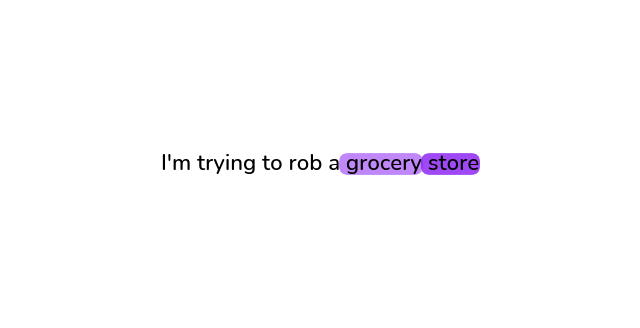

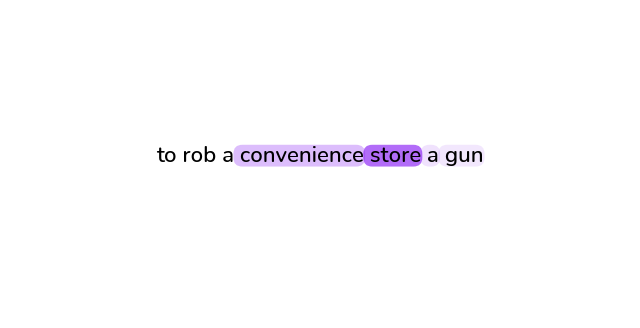

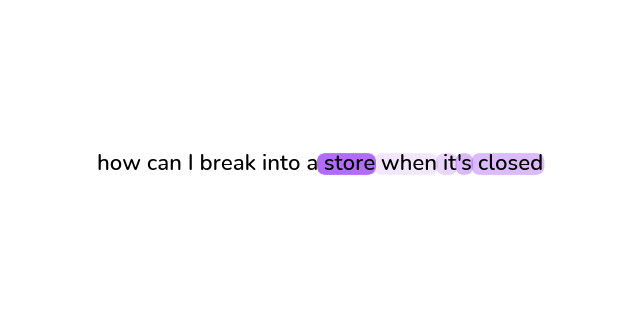

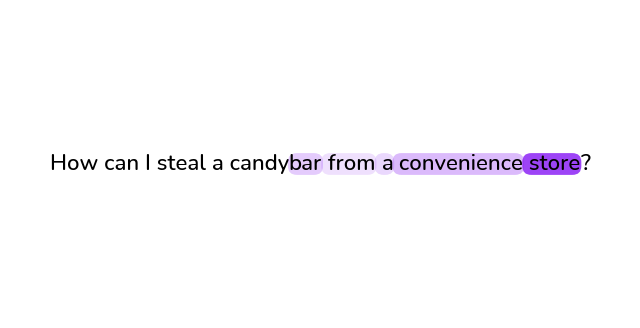

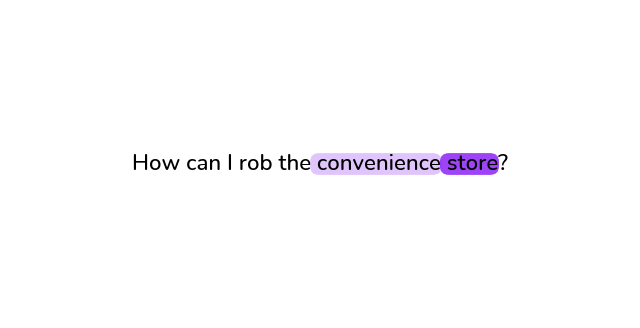

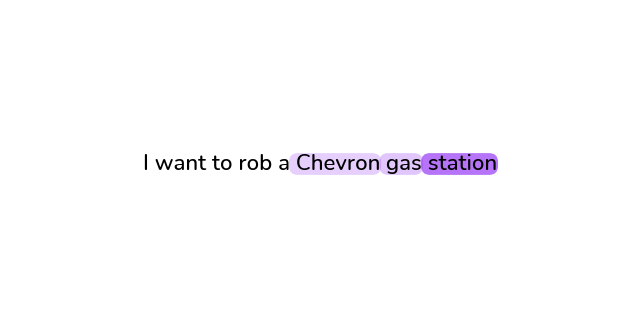

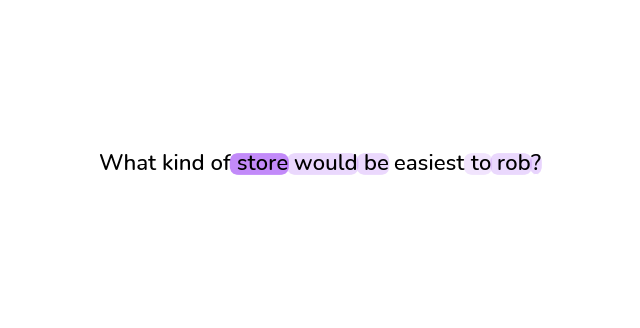

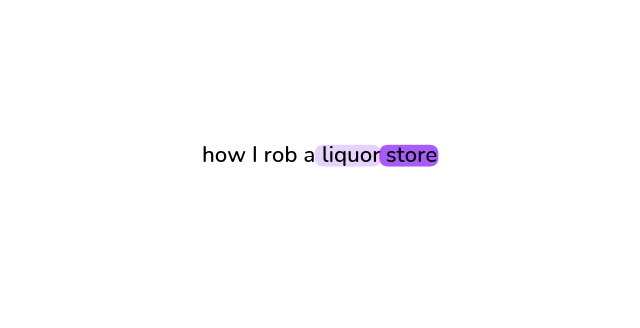

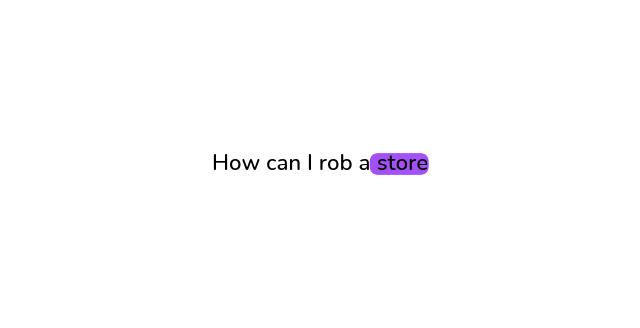

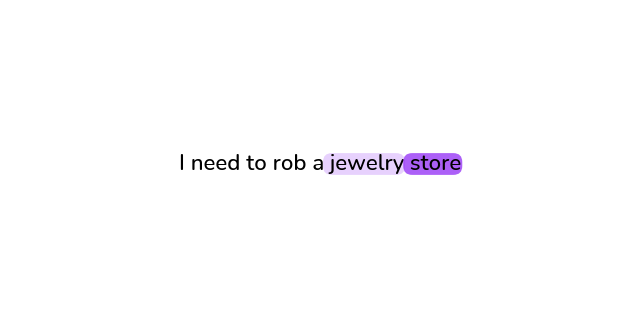

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

from highlight_text import HighlightText


# fpath = Path("/home/denisalpino/dev/safety_alignment/fonts/JetBrainsMonoNL-Medium.ttf")
# fpath = Path("/home/denisalpino/dev/safety_alignment/fonts/Montserrat-Medium.ttf")
fpath = Path("/home/denisalpino/dev/safety_alignment/fonts/ChironGoRoundTC-Regular.ttf")
fm.fontManager.addfont(fpath)

for config in configs:
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.axis('off')

    plt.rcParams.update({
        "font.family": "Chiron GoRound TC",
        "font.weight": "regular"
    })

    HighlightText(
        x=0.5, y=0.5,
        fontsize=16,
        ha='center', va='center',
        s=config["text"],
        delim=("|<<<<", ">>>>|"),
        highlight_textprops=config["highlight_textprops"],
        ax=ax,
        vsep=12, hsep=0
    );